# Import Required Libraries

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from torchvision.utils import make_grid

from collections import OrderedDict
import tqdm

# Check for GPU and Load Data

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# normalizing and loading training images
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
train_data = datasets.ImageFolder('dataset/data/train/', transform = train_transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

# normalizing and loading validation images
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
val_data = datasets.ImageFolder('dataset/data/validation/', transform = val_transform)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

# # normalizing and loading test images
# test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
# test_data = datasets.ImageFolder('dataset/data/test/', transform = test_transform)
# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Construct Model

In [4]:
# using pretrained VGG-11
model = models.vgg11(pretrained = True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [5]:
class VGG11(nn.Module):
    
    def __init__(self, num_classes):
        '''Transfer learning on VGG-11 by changing its classifier layer'''
        
        super(VGG11, self).__init__()
        self.num_classes = num_classes
        
        self.model = models.vgg11(pretrained = True)
        
        self.model.classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 512)),
            ('relu', nn.ReLU()), 
            ('dropout', nn.Dropout(p = 0.5)),
            ('fc2', nn.Linear(512, self.num_classes)),
            ('output', nn.LogSoftmax(dim = 1))]))
    
    def forward(self, x):
        '''Modified forward function'''
        x = self.model.features(x)
        x = self.model.avgpool(x)
        # flatten to prepare for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.model.classifier(x)
        return x

In [6]:
#number of classes = 2
model = VGG11(2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

# Training Function

In [7]:
def train (model, train_loader, optimizer, criterion):
    '''Training function'''
    
    model.train()
    
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    
    for i, data in enumerate(iter(train_loader)):
        counter += 1
        
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model.forward(image)
        
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()

        
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    
    return epoch_loss, epoch_acc


# Validation Function

In [8]:
def validate(model, val_loader, criterion):
    '''Validation function'''
    
    model.eval()
    
    # we need two lists to keep track of class-wise accuracy
    class_correct = list(0. for i in range(2))
    class_total = list(0. for i in range(2))
    
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    
    with torch.no_grad():
        for i, data in enumerate(iter(val_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            
            outputs = model(image)

            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()

            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            correct  = (preds == labels).squeeze()
            
            for i in range(len(preds)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(val_loader.dataset))

    # number of classes=2
    for i in range(2):
        print(f"Accuracy of class {i}: {100*class_correct[i]/class_total[i]}")
    return epoch_loss, epoch_acc

# Training Loop

In [9]:
# freezing pretrained parameters
for param in model.parameters():
    param.require_grad = False
    
epochs = 10  
epoch = 0
    
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
    
for e in range(epochs):
    epoch += 1
    print('\nEpoch:', epoch)
    
    with torch.set_grad_enabled(True):
        epoch_train_loss, epoch_train_acc = train(model.to(device),train_loader, optimizer, criterion)
        print("Epoch: {} Train Loss : {:.4f}  Train Accuracy: {:.4f}".format(epoch,epoch_train_loss,epoch_train_acc))
    
    with torch.no_grad():
        epoch_val_loss, epoch_val_acc = validate(model.to(device),train_loader, criterion.to(device))
        print("Epoch: {} Validation Loss : {:.4f}  Validation Accuracy {:.4f}".format(epoch,epoch_val_loss,epoch_val_acc))
        
    train_loss.append(epoch_train_loss)
    valid_loss.append(epoch_val_loss)
    train_acc.append(epoch_train_acc)
    valid_acc.append(epoch_val_acc)
    
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './outputs/model-'+ str(e) + '-val-' + str(epoch_val_acc) + '.pth')


Epoch: 1
Training
Epoch: 1 Train Loss : 0.4750  Train Accuracy: 77.0527
Validation
Accuracy of class 0: 92.58435298479792
Accuracy of class 1: 99.19678714859438
Epoch: 1 Validation Loss : 0.3526  Validation Accuracy 95.3935

Epoch: 2
Training
Epoch: 2 Train Loss : 0.0504  Train Accuracy: 98.9550
Validation
Accuracy of class 0: 100.0
Accuracy of class 1: 100.0
Epoch: 2 Validation Loss : 0.0014  Validation Accuracy 100.0000

Epoch: 3
Training
Epoch: 3 Train Loss : 0.0207  Train Accuracy: 99.2962
Validation
Accuracy of class 0: 100.0
Accuracy of class 1: 36.04417670682731
Epoch: 3 Validation Loss : 1.0586  Validation Accuracy 72.8300

Epoch: 4
Training
Epoch: 4 Train Loss : 0.8046  Train Accuracy: 58.4773
Validation
Accuracy of class 0: 97.10789766407119
Accuracy of class 1: 24.799196787148595
Epoch: 4 Validation Loss : 0.6368  Validation Accuracy 66.3894

Epoch: 5
Training
Epoch: 5 Train Loss : 0.4721  Train Accuracy: 77.5645
Validation
Accuracy of class 0: 69.07675194660735
Accuracy of

# Predictions

In [ ]:
model.eval()
total = 0
correct = 0 
count = 0

#iterating for each sample in the test dataset once
for i, data in enumerate(iter(test_loader)):
    
    image, labels = data
    image = image.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        # log of output probabilities
        outputs = model.forward(image)
        
        # output probabilities
        ps = torch.exp(outputs)
        
        # class predictions
        _, predicted = torch.max(outputs.data,1)
        
        print('Predictions:', predicted)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item() 
        count += 1
        
        print("Accuracy of network on test images is ... {:.4f}....count: {}".format(100*correct/total,  count ))

In [ ]:
# testing and visualizing output for one image
model = VGG11(num_classes=2)
checkpoint = torch.load('./outputs/model-9-val-100.0.pth')

model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

img = cv2.imread('./dataset/data/test/Mark_Wahlberg/829.jpg')
img = transform(img)
img = img.unsqueeze(0).to(device)

outputs = model(img)
label = np.array(outputs.detach().cpu()).argmax()
print(label)

In [ ]:
print(model)

# Visualization

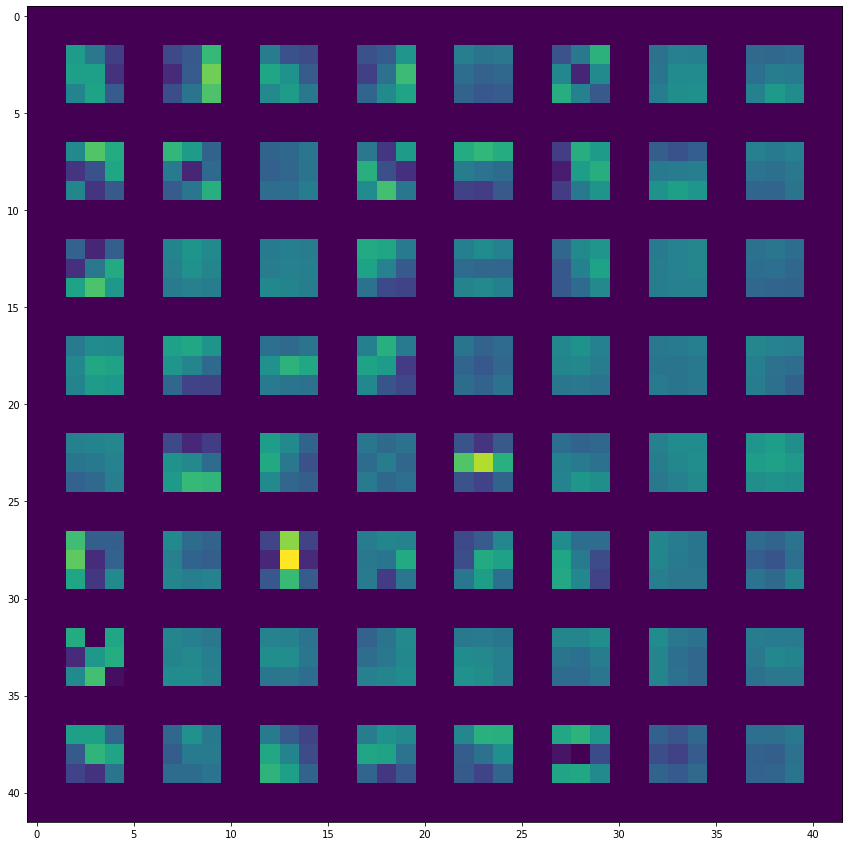

In [11]:
# visualizing the filters/kernels of a layer
layer = 0

kernels = model.model.features[layer].weight.detach().clone()
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

img = make_grid(kernels)
plt.figure(figsize = (15,15))
plt.imshow(img.permute(1, 2, 0)[:, :, 1].cpu())

In [12]:
# hooking up layers to plot activations for each layer
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [13]:
# list of indices for convolutional layers in the model
conv_layers = [0, 3, 6, 8, 11, 13, 16, 18]
layer_count = 1

for layer in conv_layers:
    model.model.features[layer].register_forward_hook(get_activation('conv' + str(layer_count)))
    
    data, _ = val_data[0]
    data.unsqueeze_(0)
    output = model(data.cuda())
    
    layer_count += 1
    
    print('Class Probabilities according to layer conv' + str(layer_count) + ':', output.cpu())

Class Probabilities according to layer conv2: tensor([[-3.5763e-07, -1.4969e+01]], grad_fn=<ToCopyBackward0>)
Class Probabilities according to layer conv3: tensor([[-3.5763e-07, -1.4969e+01]], grad_fn=<ToCopyBackward0>)
Class Probabilities according to layer conv4: tensor([[-3.5763e-07, -1.4969e+01]], grad_fn=<ToCopyBackward0>)
Class Probabilities according to layer conv5: tensor([[-3.5763e-07, -1.4969e+01]], grad_fn=<ToCopyBackward0>)
Class Probabilities according to layer conv6: tensor([[-3.5763e-07, -1.4969e+01]], grad_fn=<ToCopyBackward0>)
Class Probabilities according to layer conv7: tensor([[-3.5763e-07, -1.4969e+01]], grad_fn=<ToCopyBackward0>)
Class Probabilities according to layer conv8: tensor([[-3.5763e-07, -1.4969e+01]], grad_fn=<ToCopyBackward0>)
Class Probabilities according to layer conv9: tensor([[-3.5763e-07, -1.4969e+01]], grad_fn=<ToCopyBackward0>)


Activations for layer: conv1
Activations for layer: conv2
Activations for layer: conv3
Activations for layer: conv4
Activations for layer: conv5
Activations for layer: conv6
Activations for layer: conv7
Activations for layer: conv8


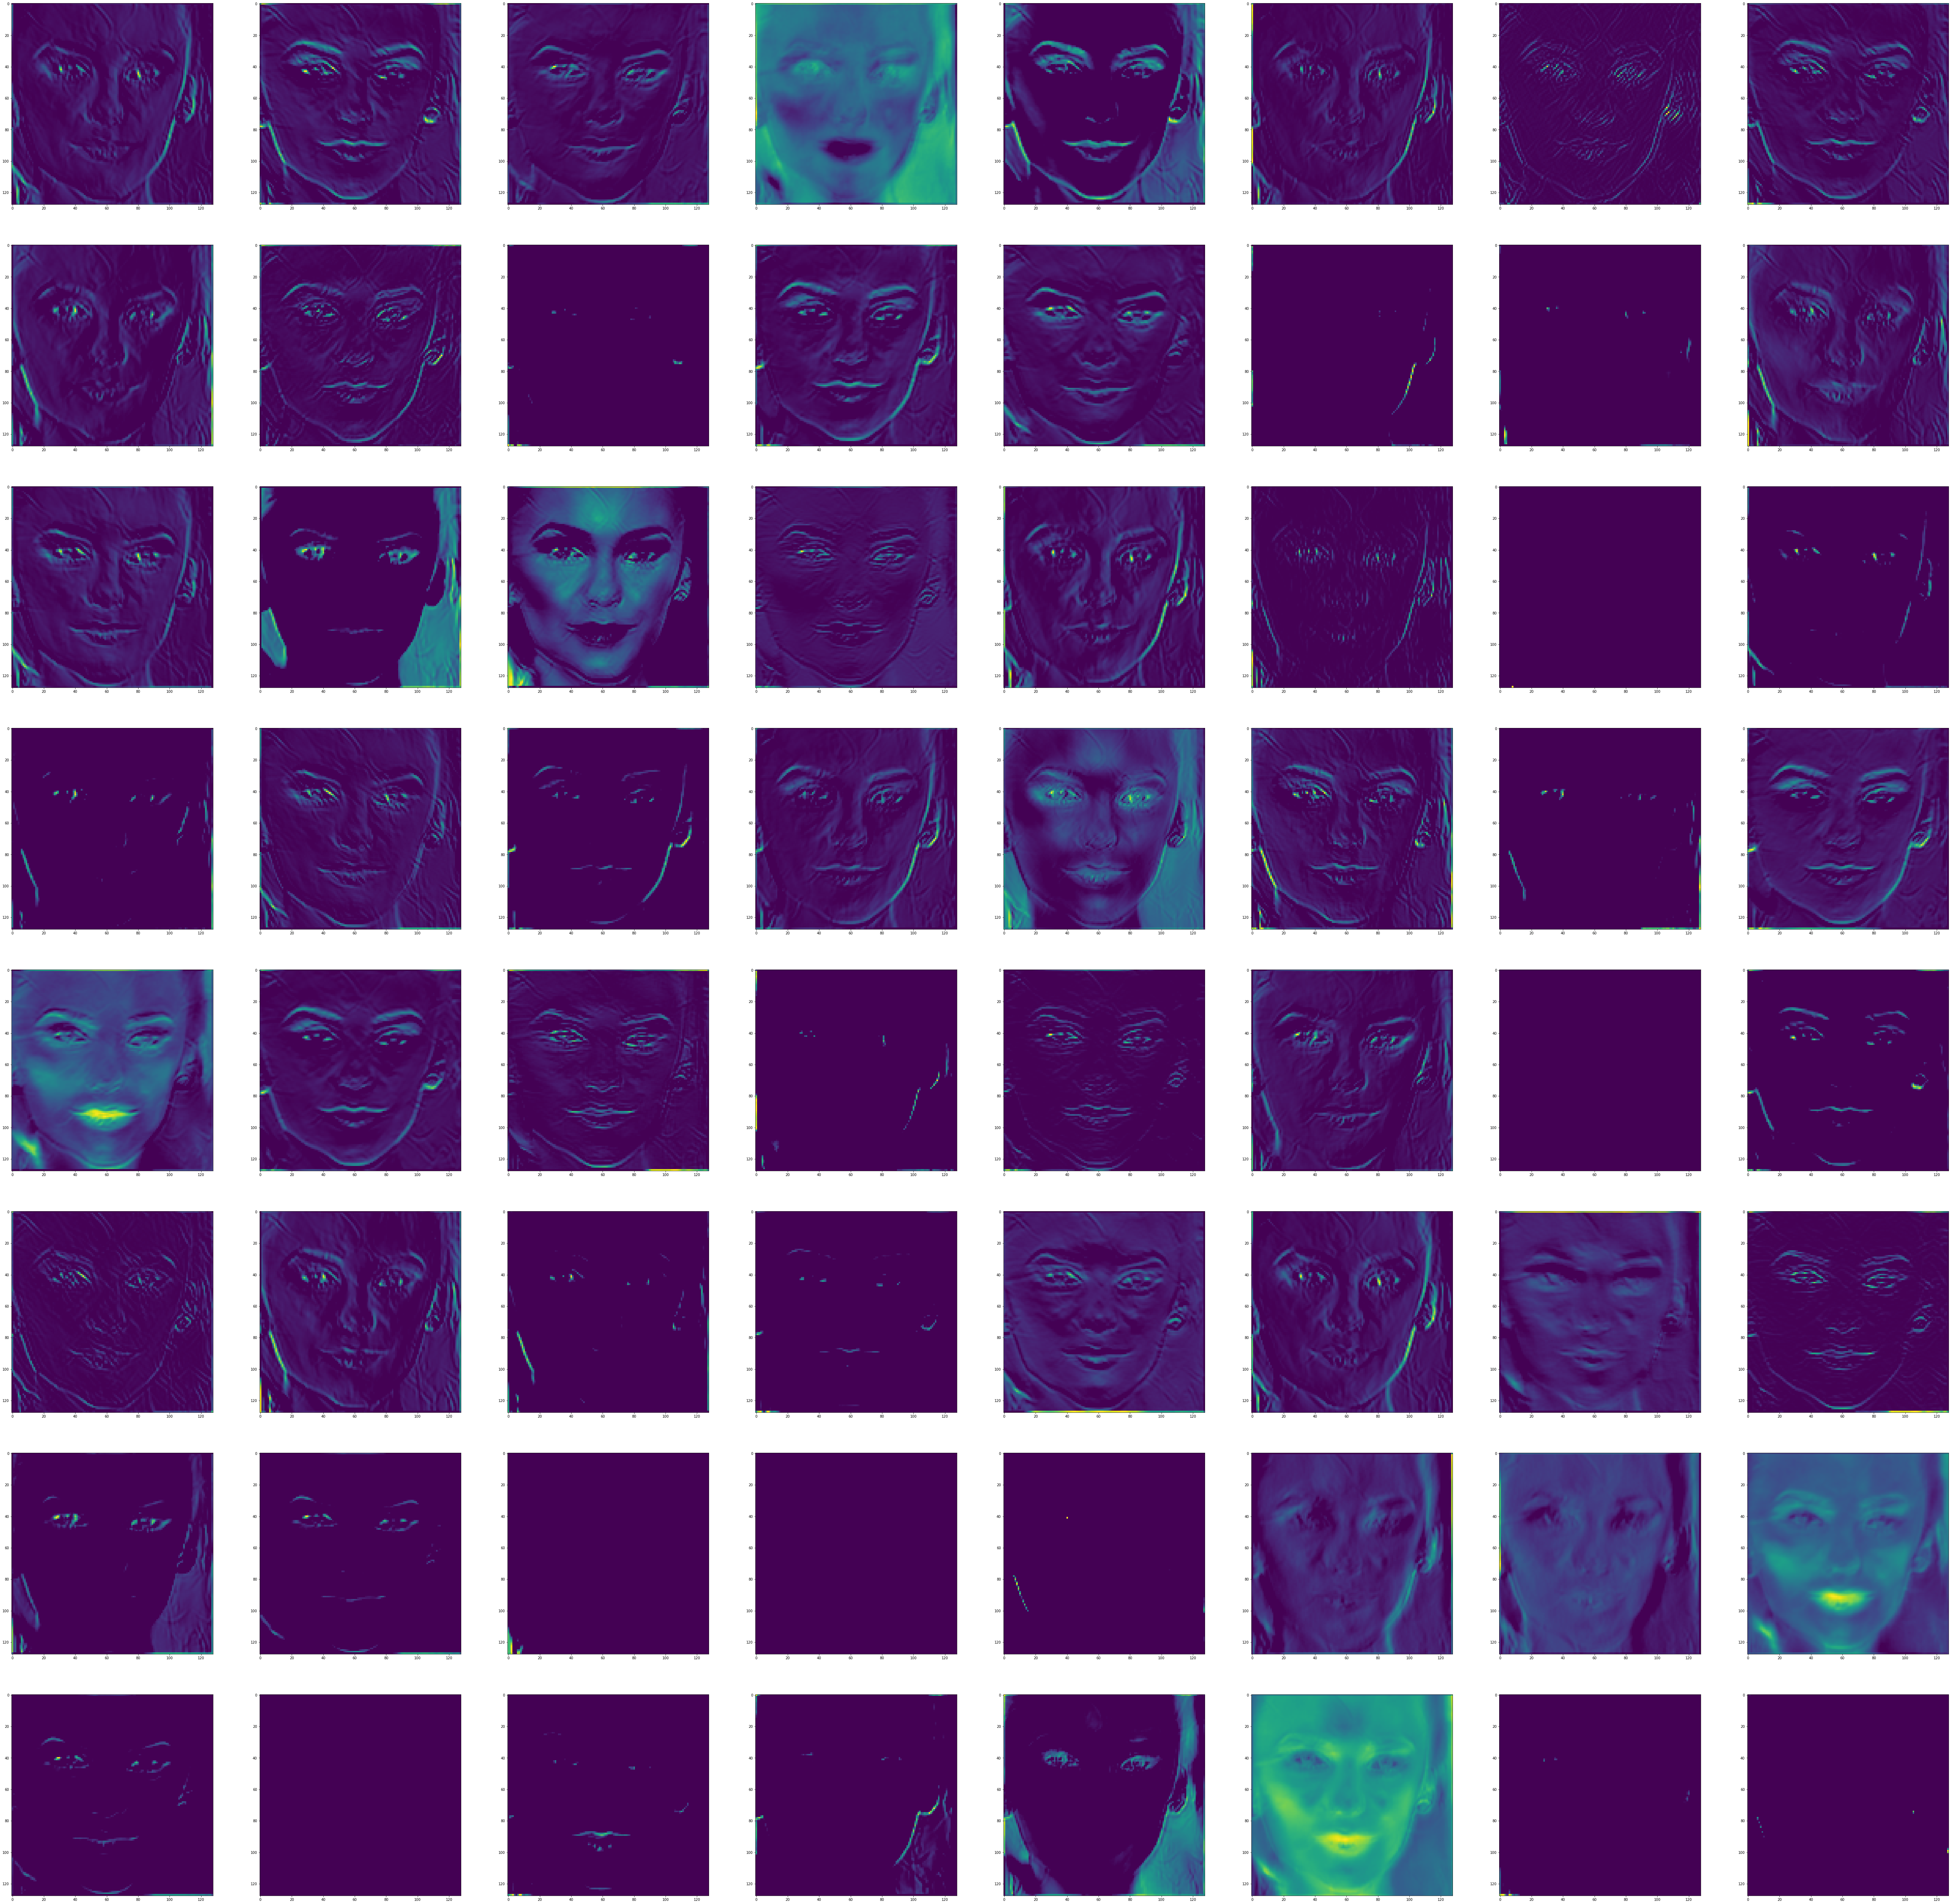

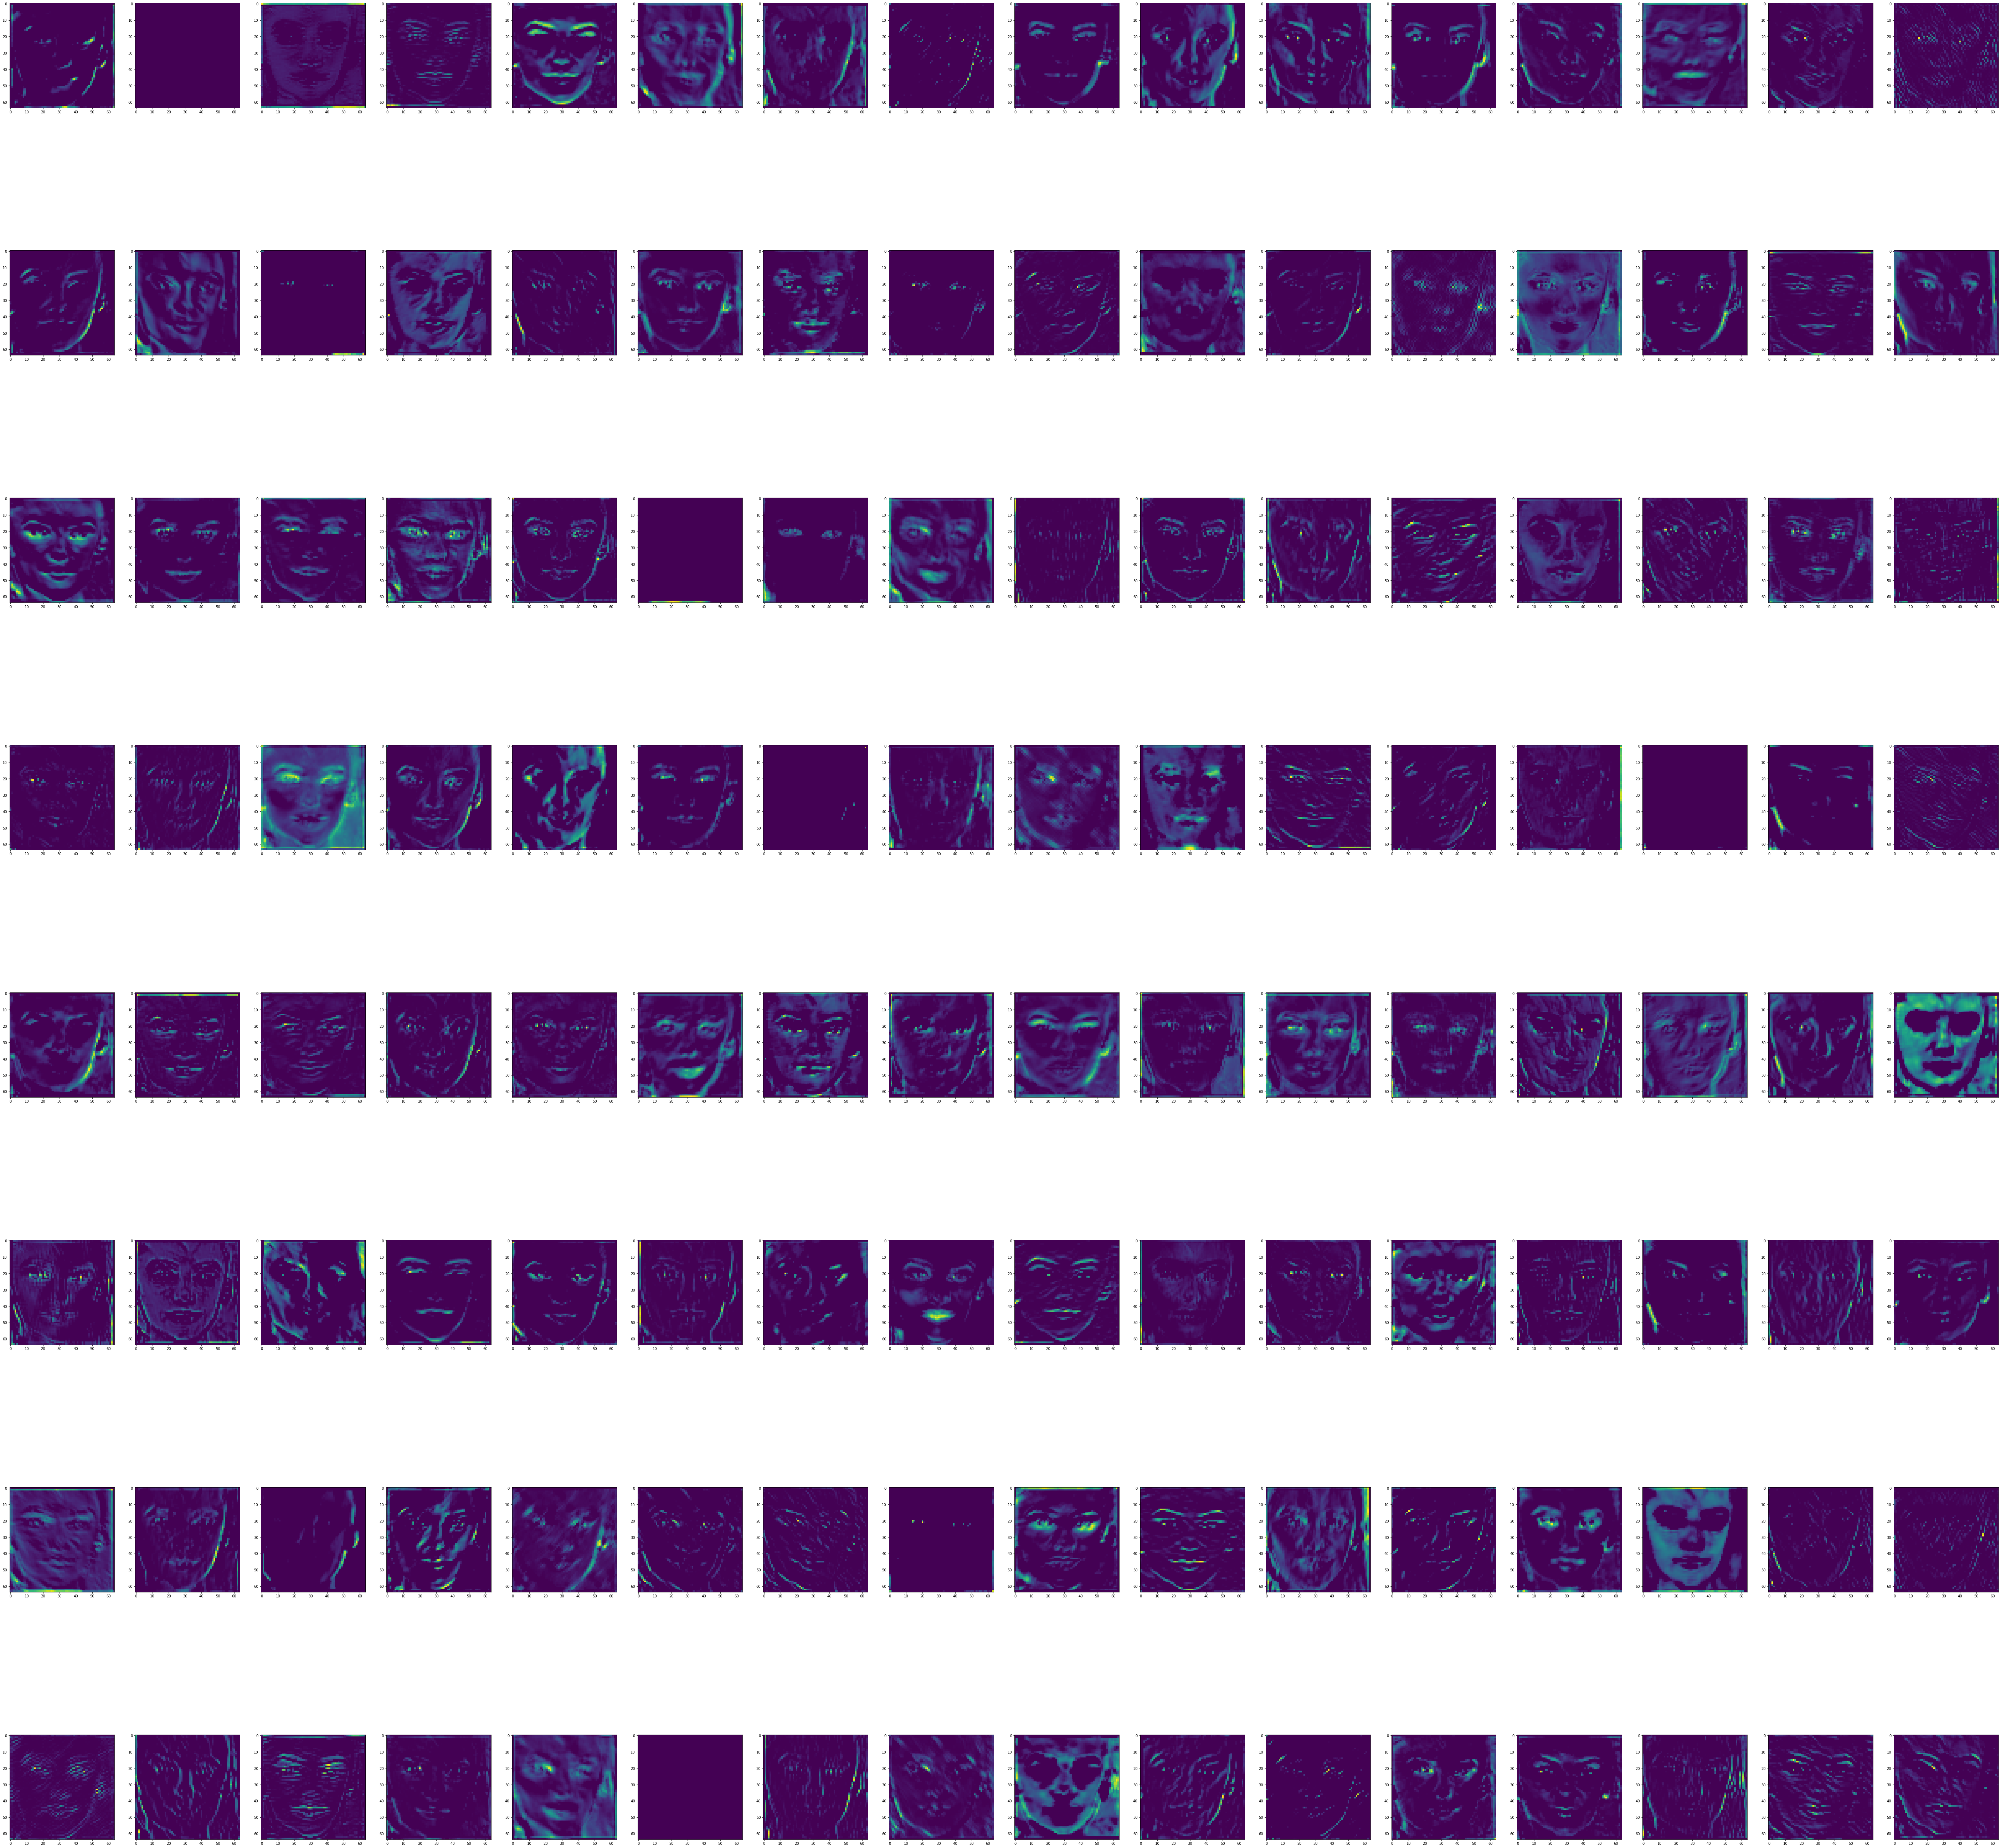

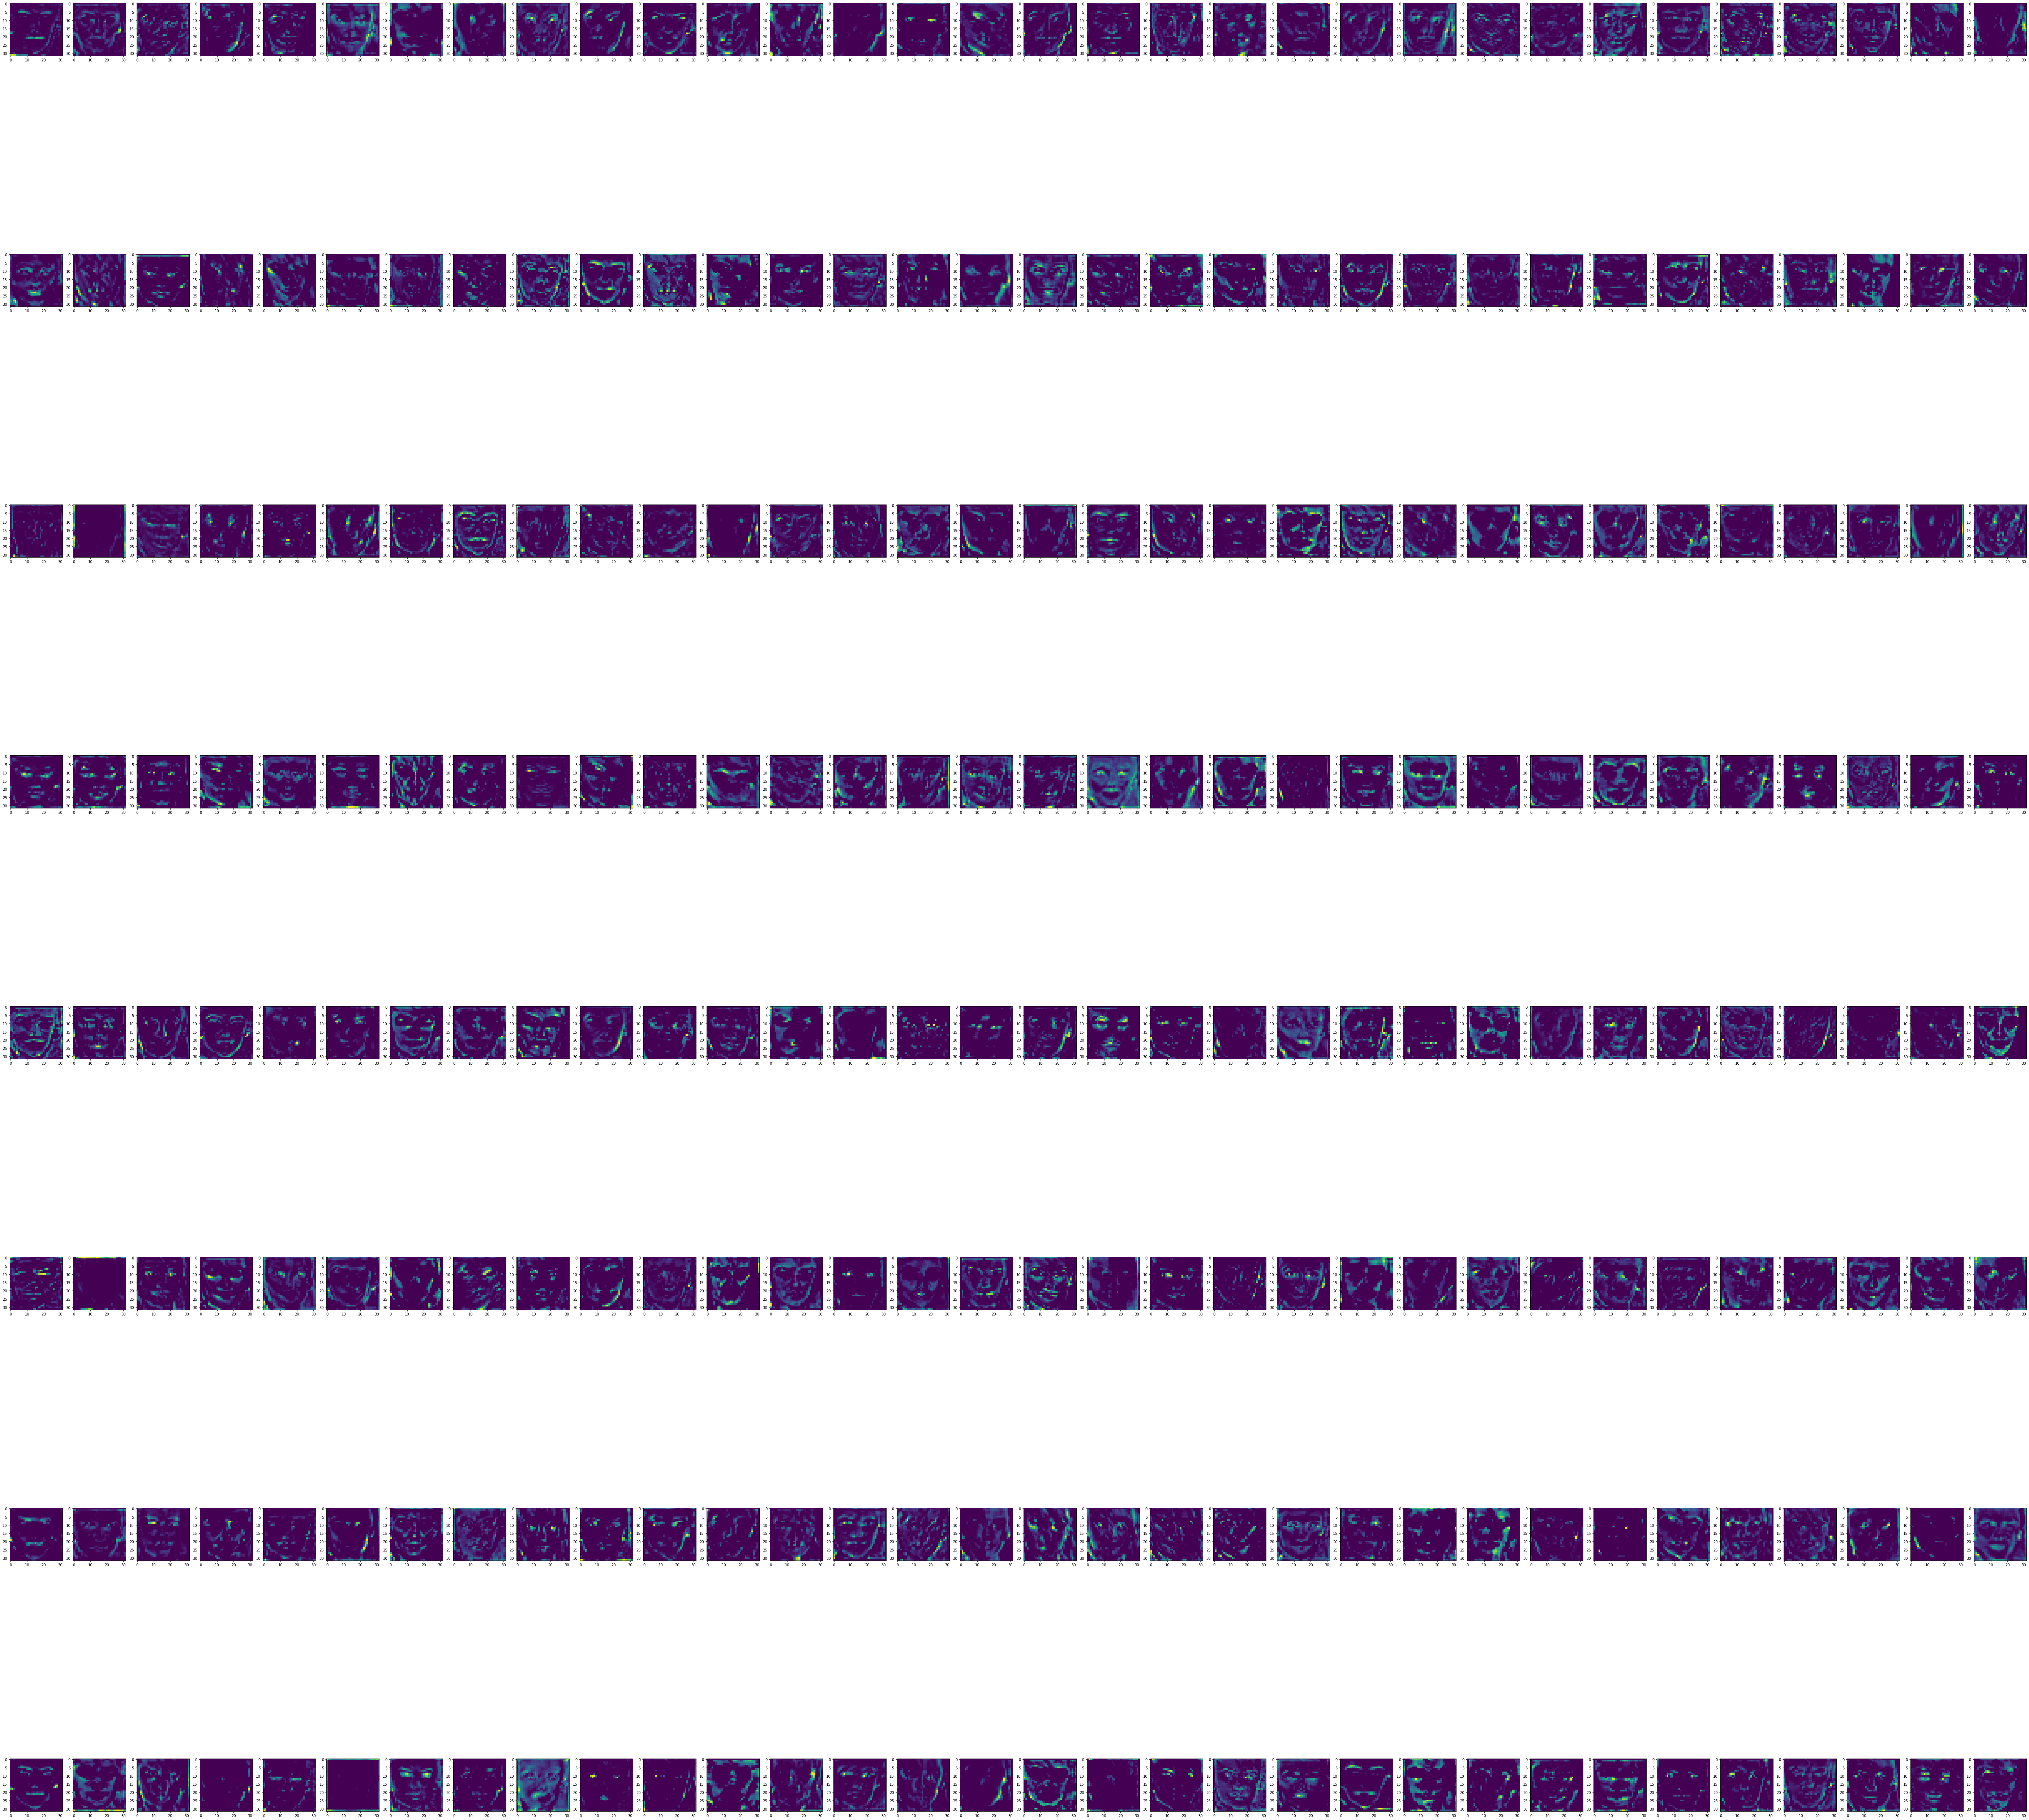

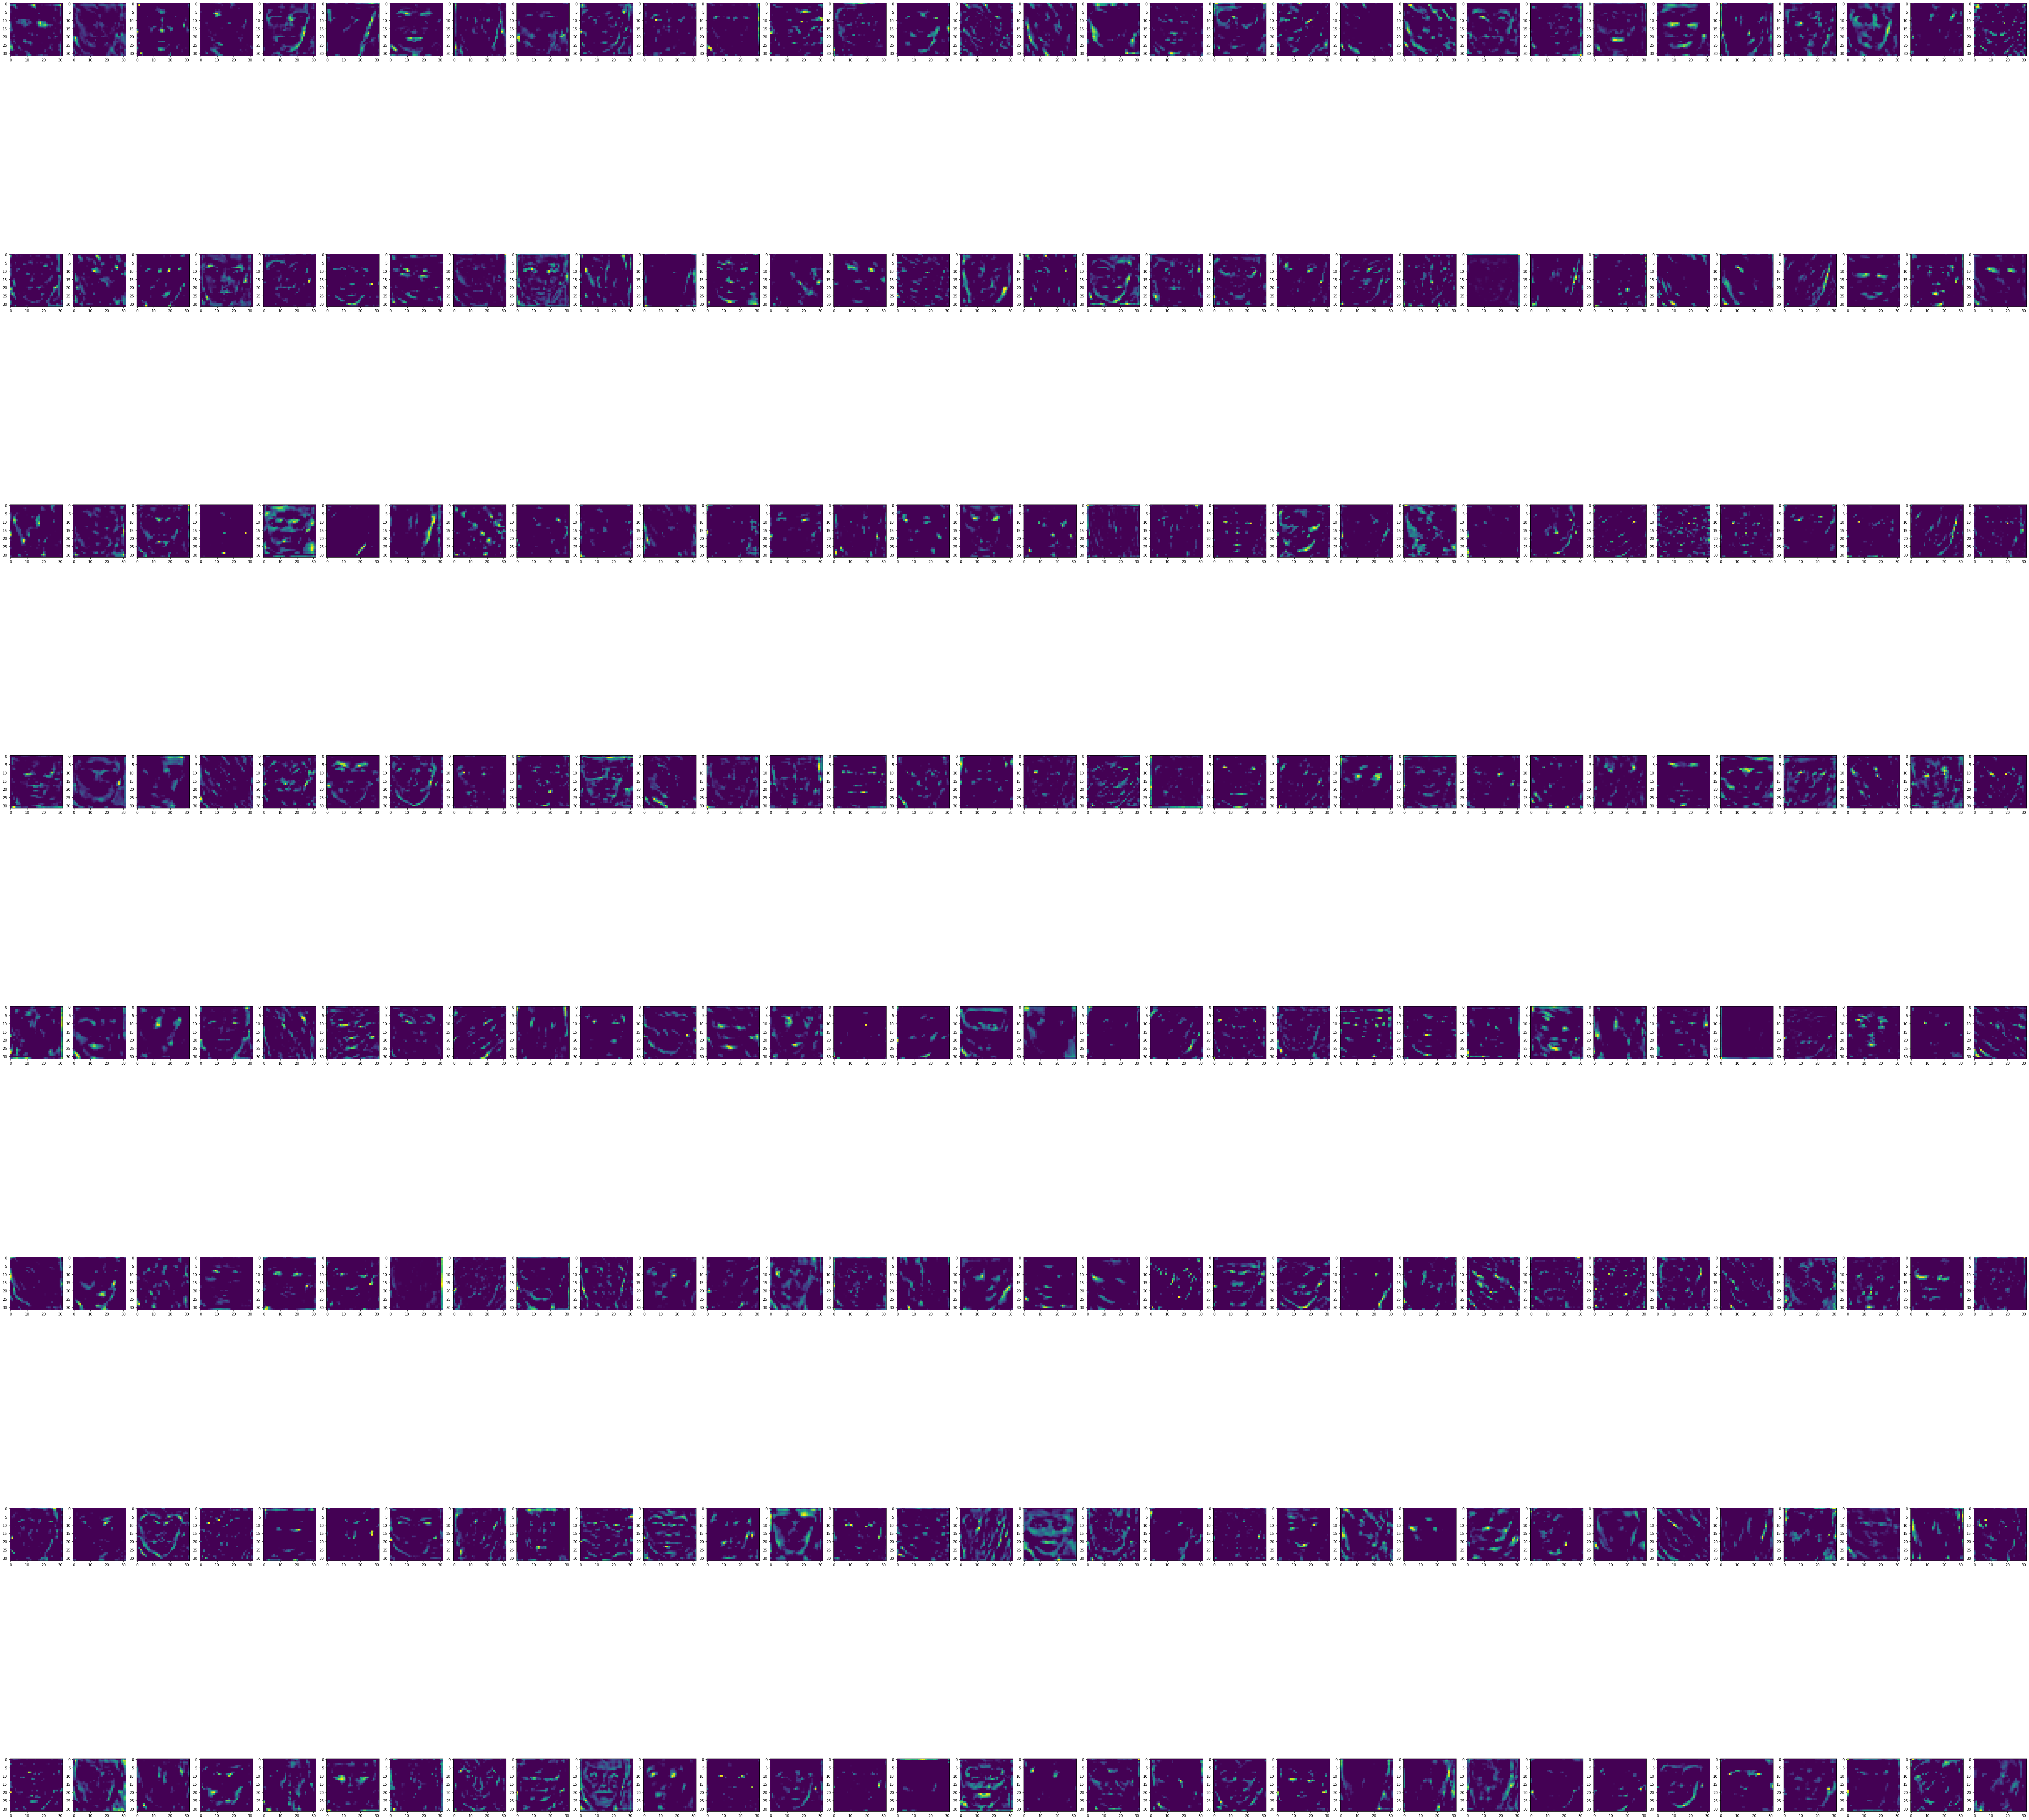

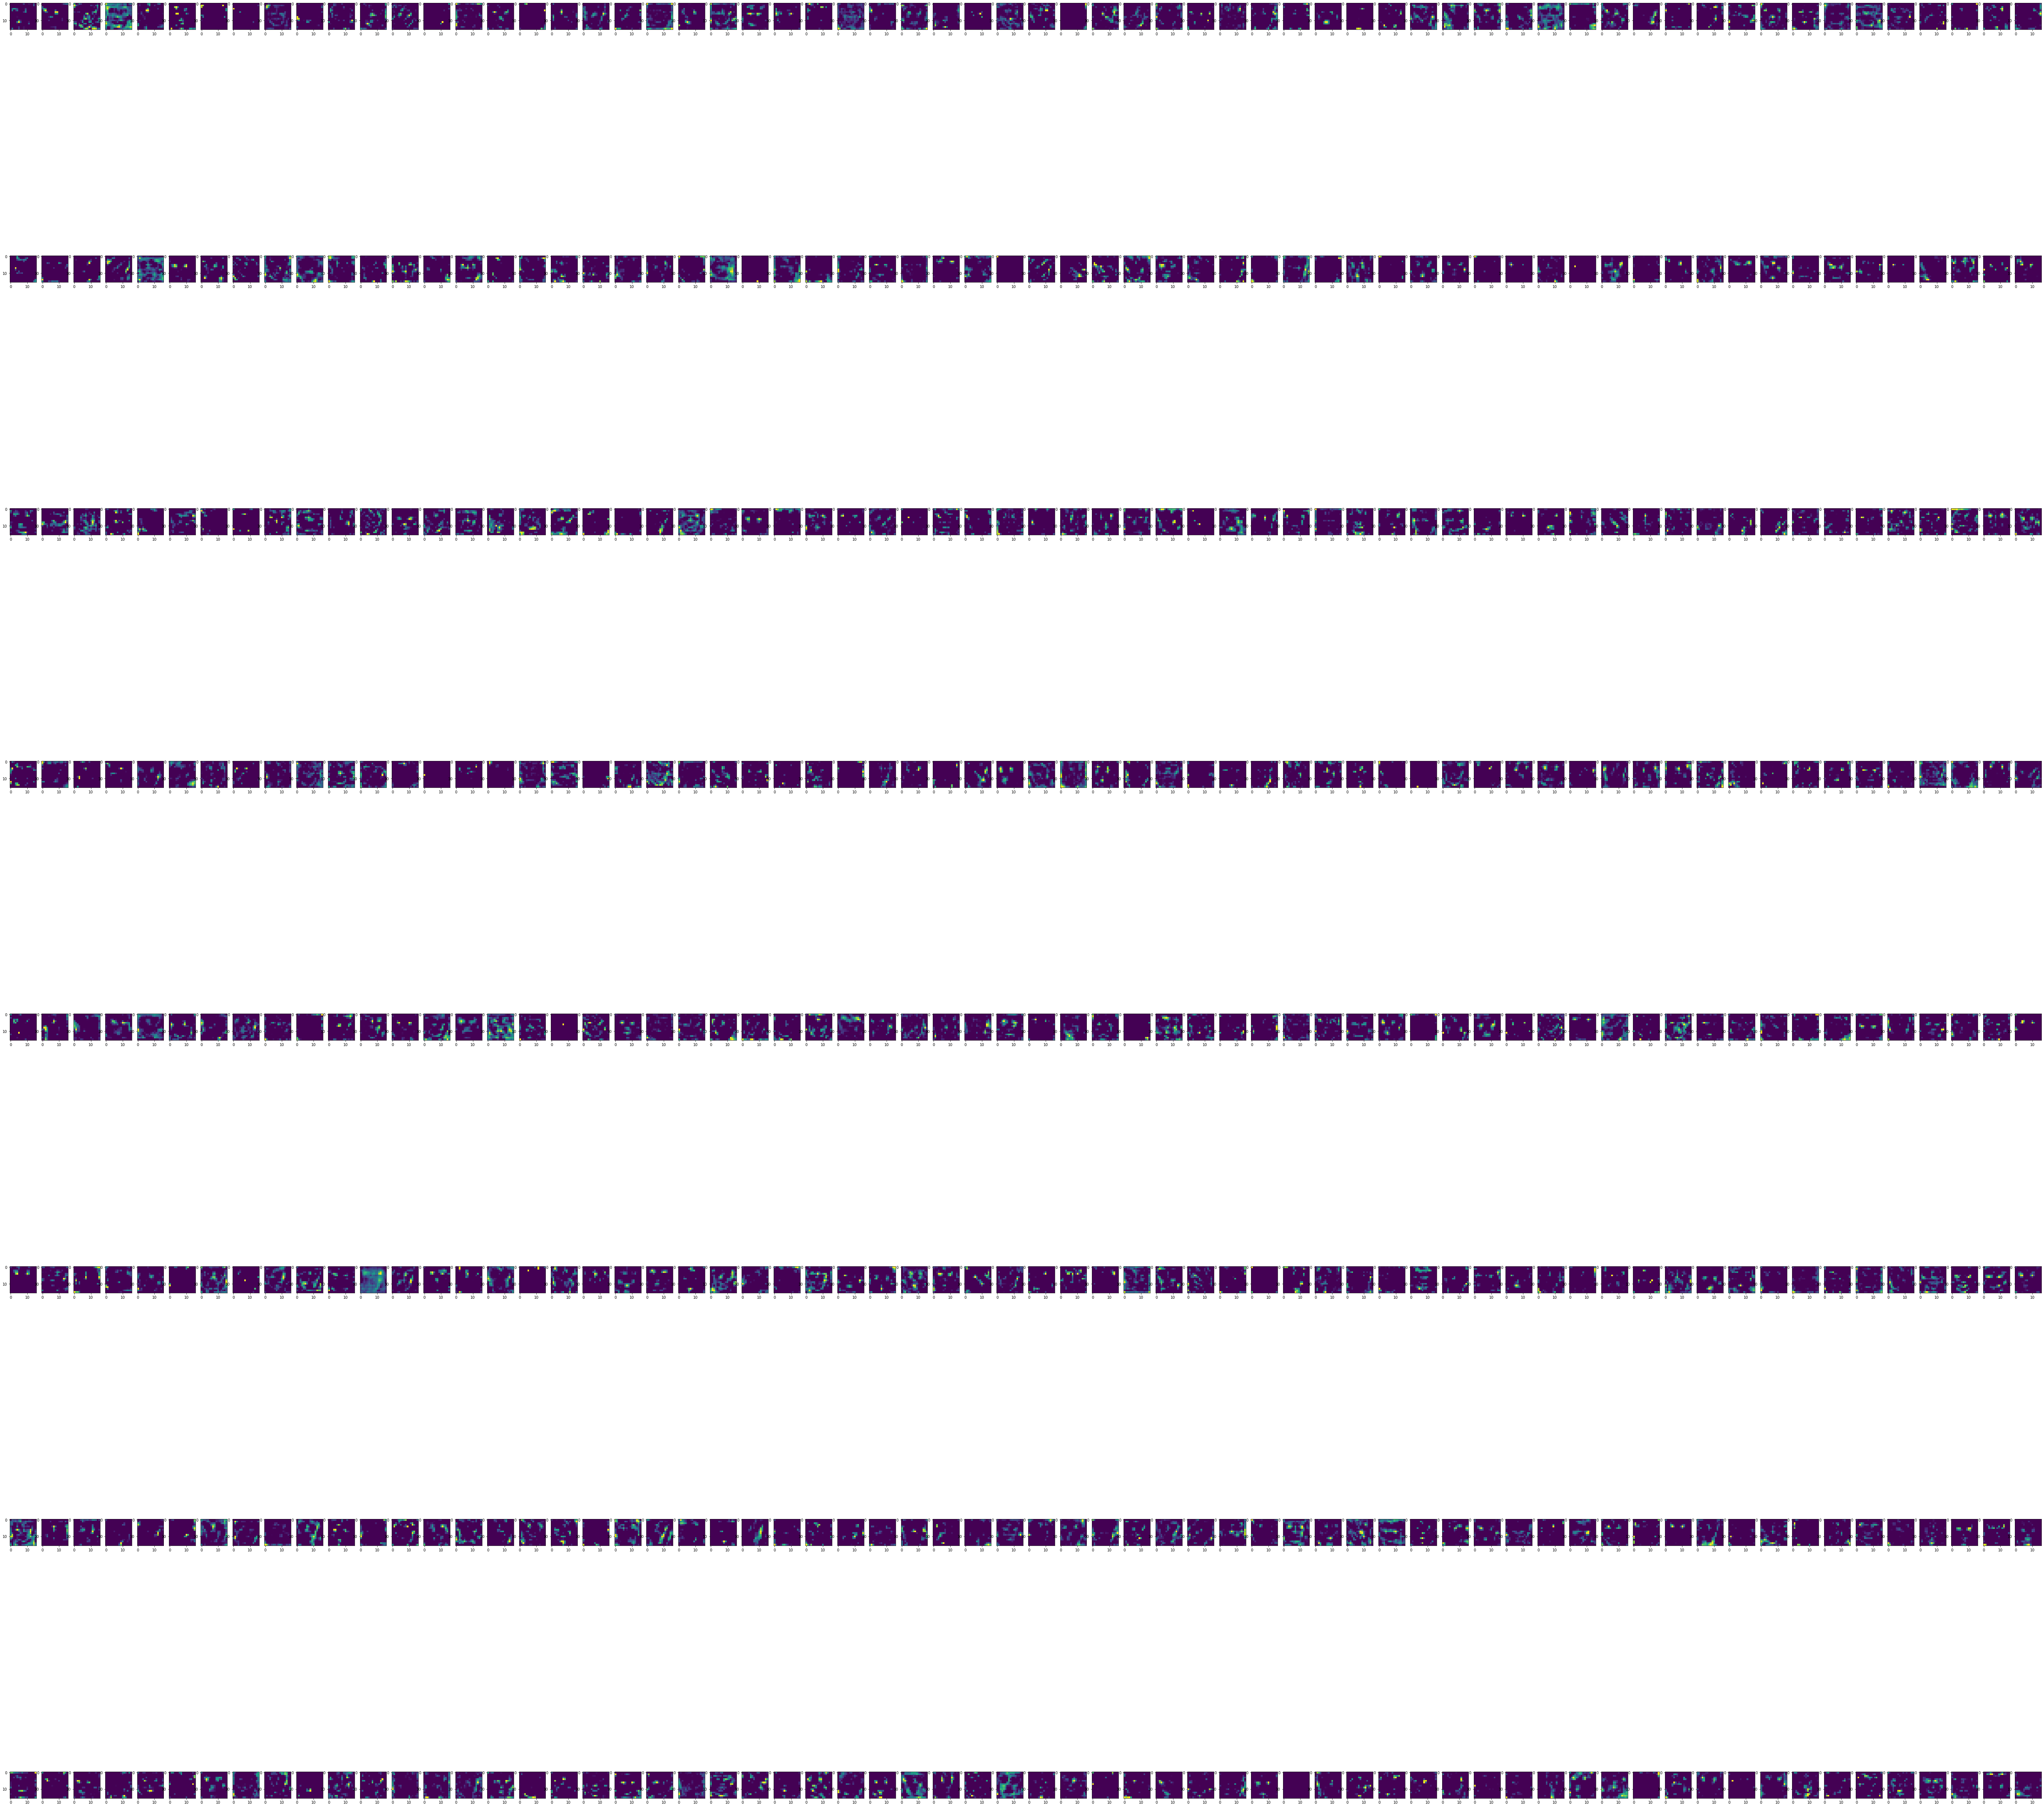

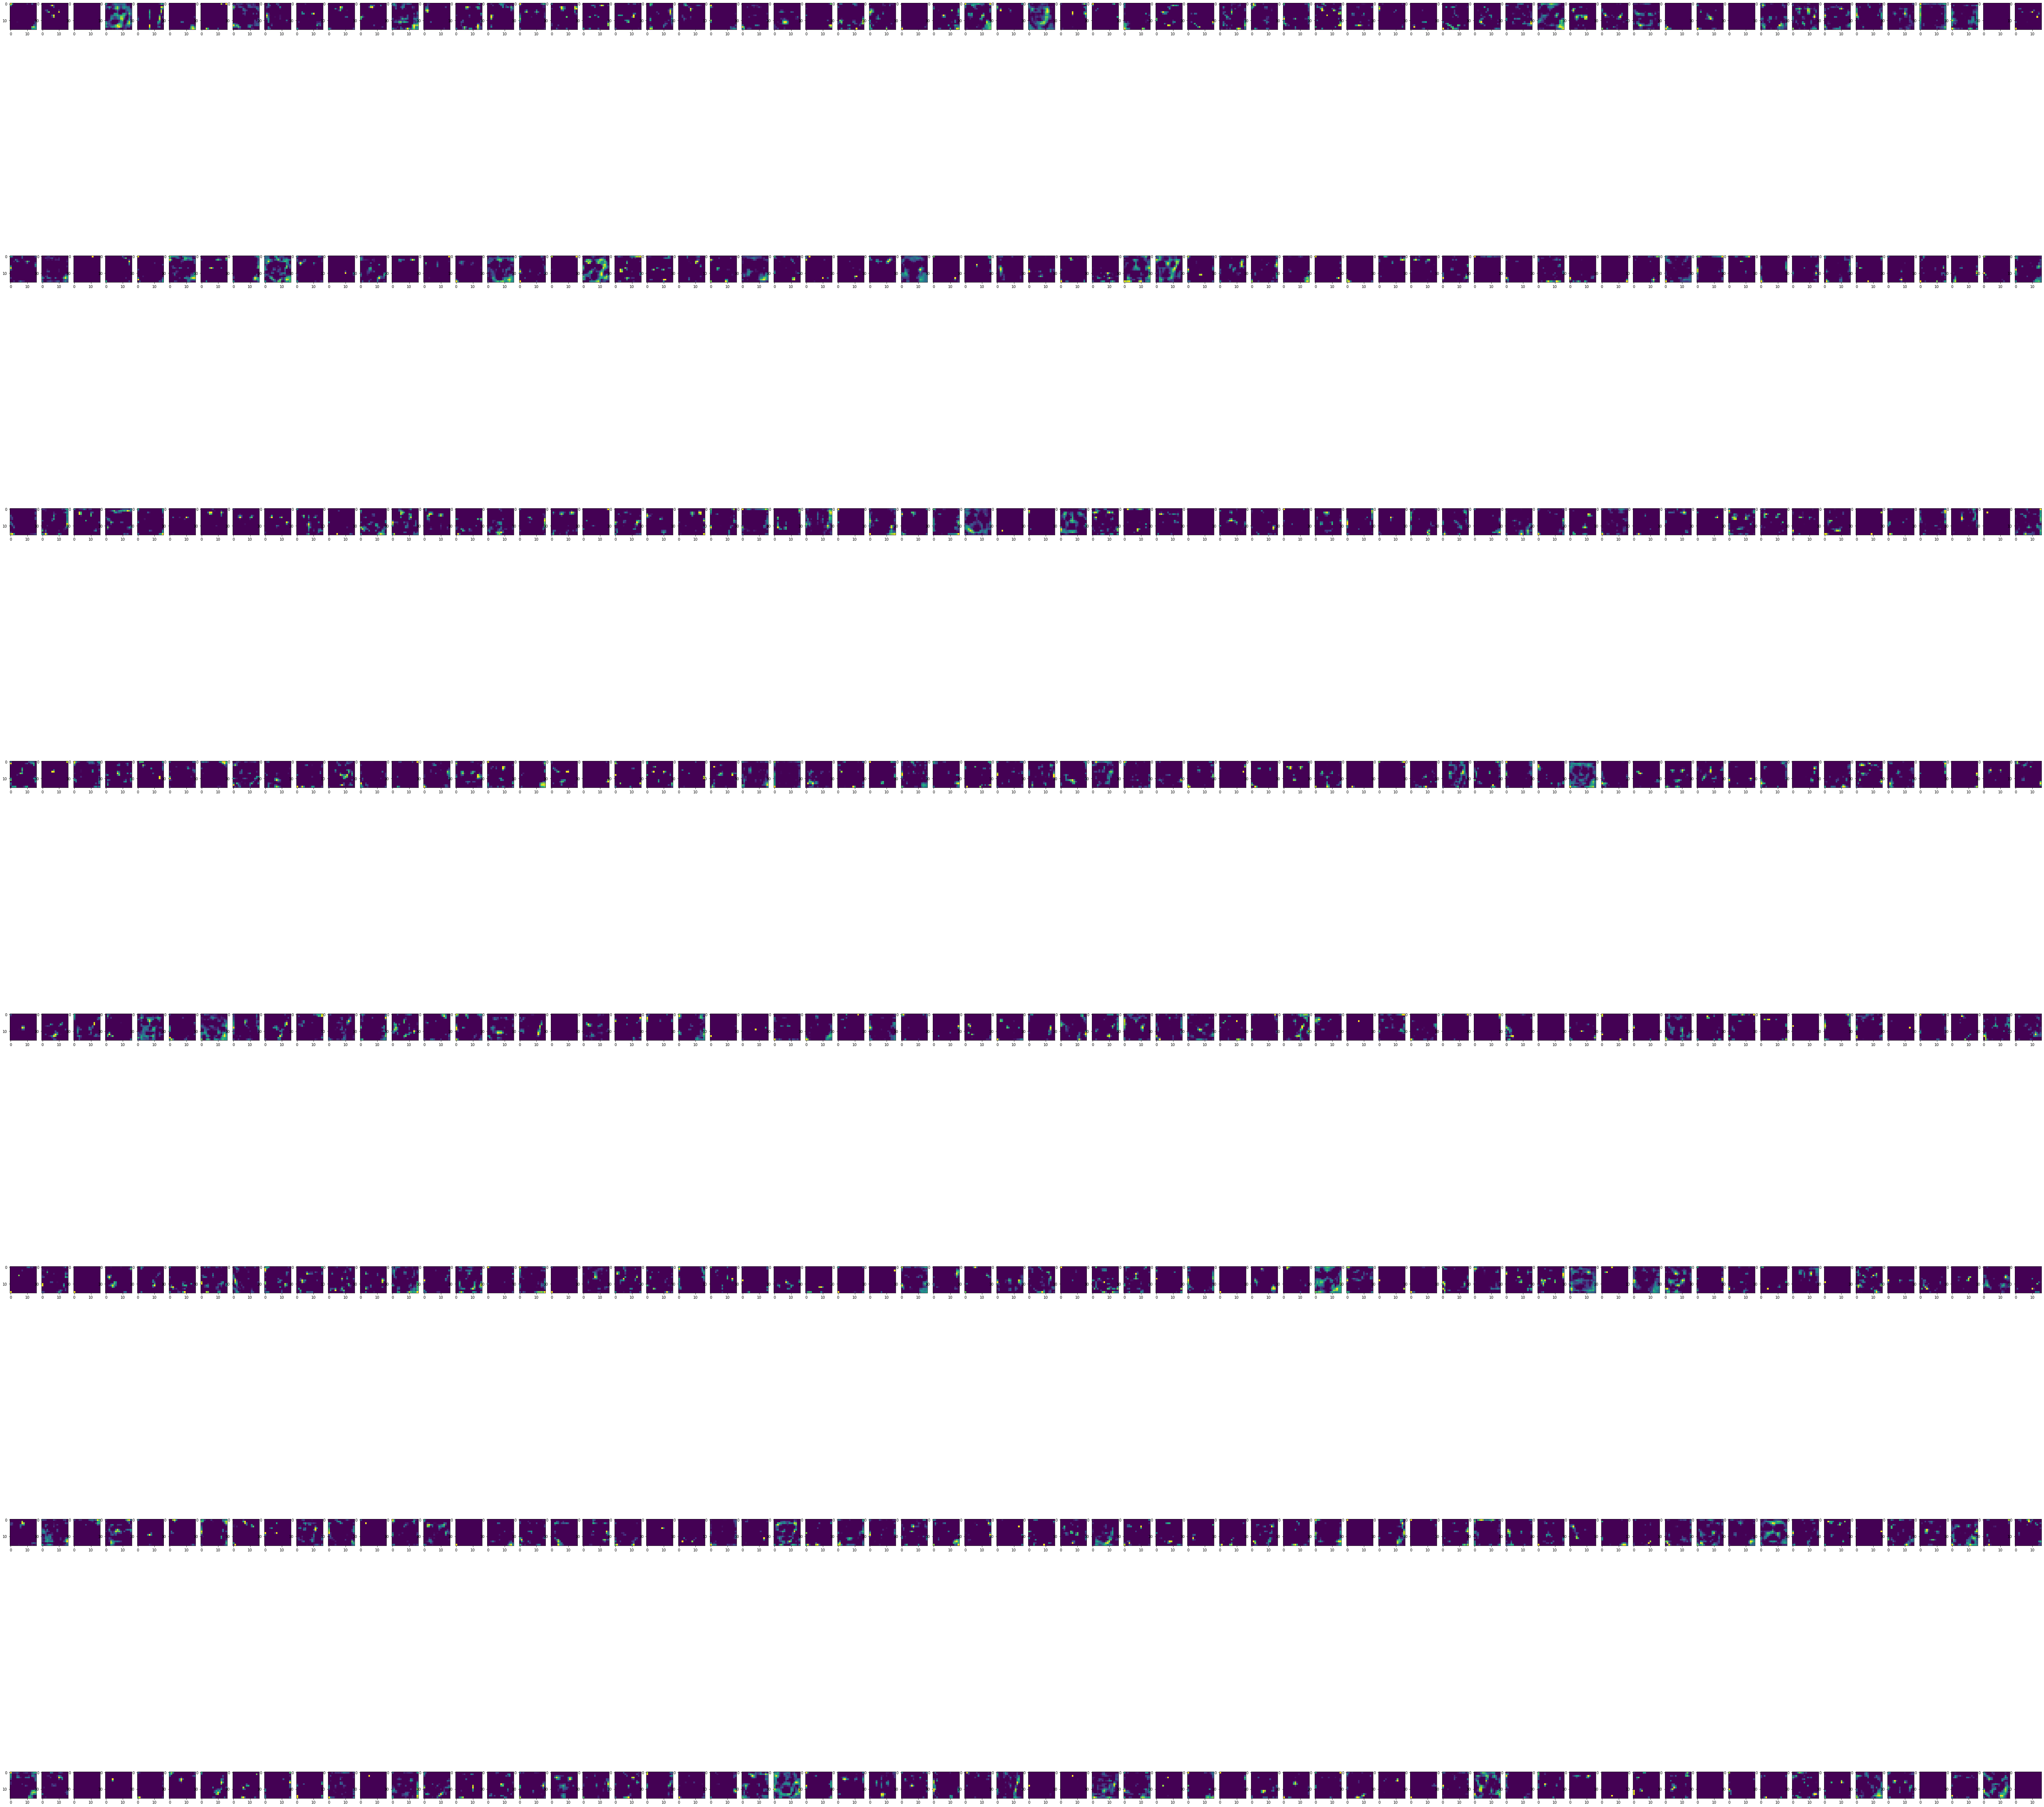

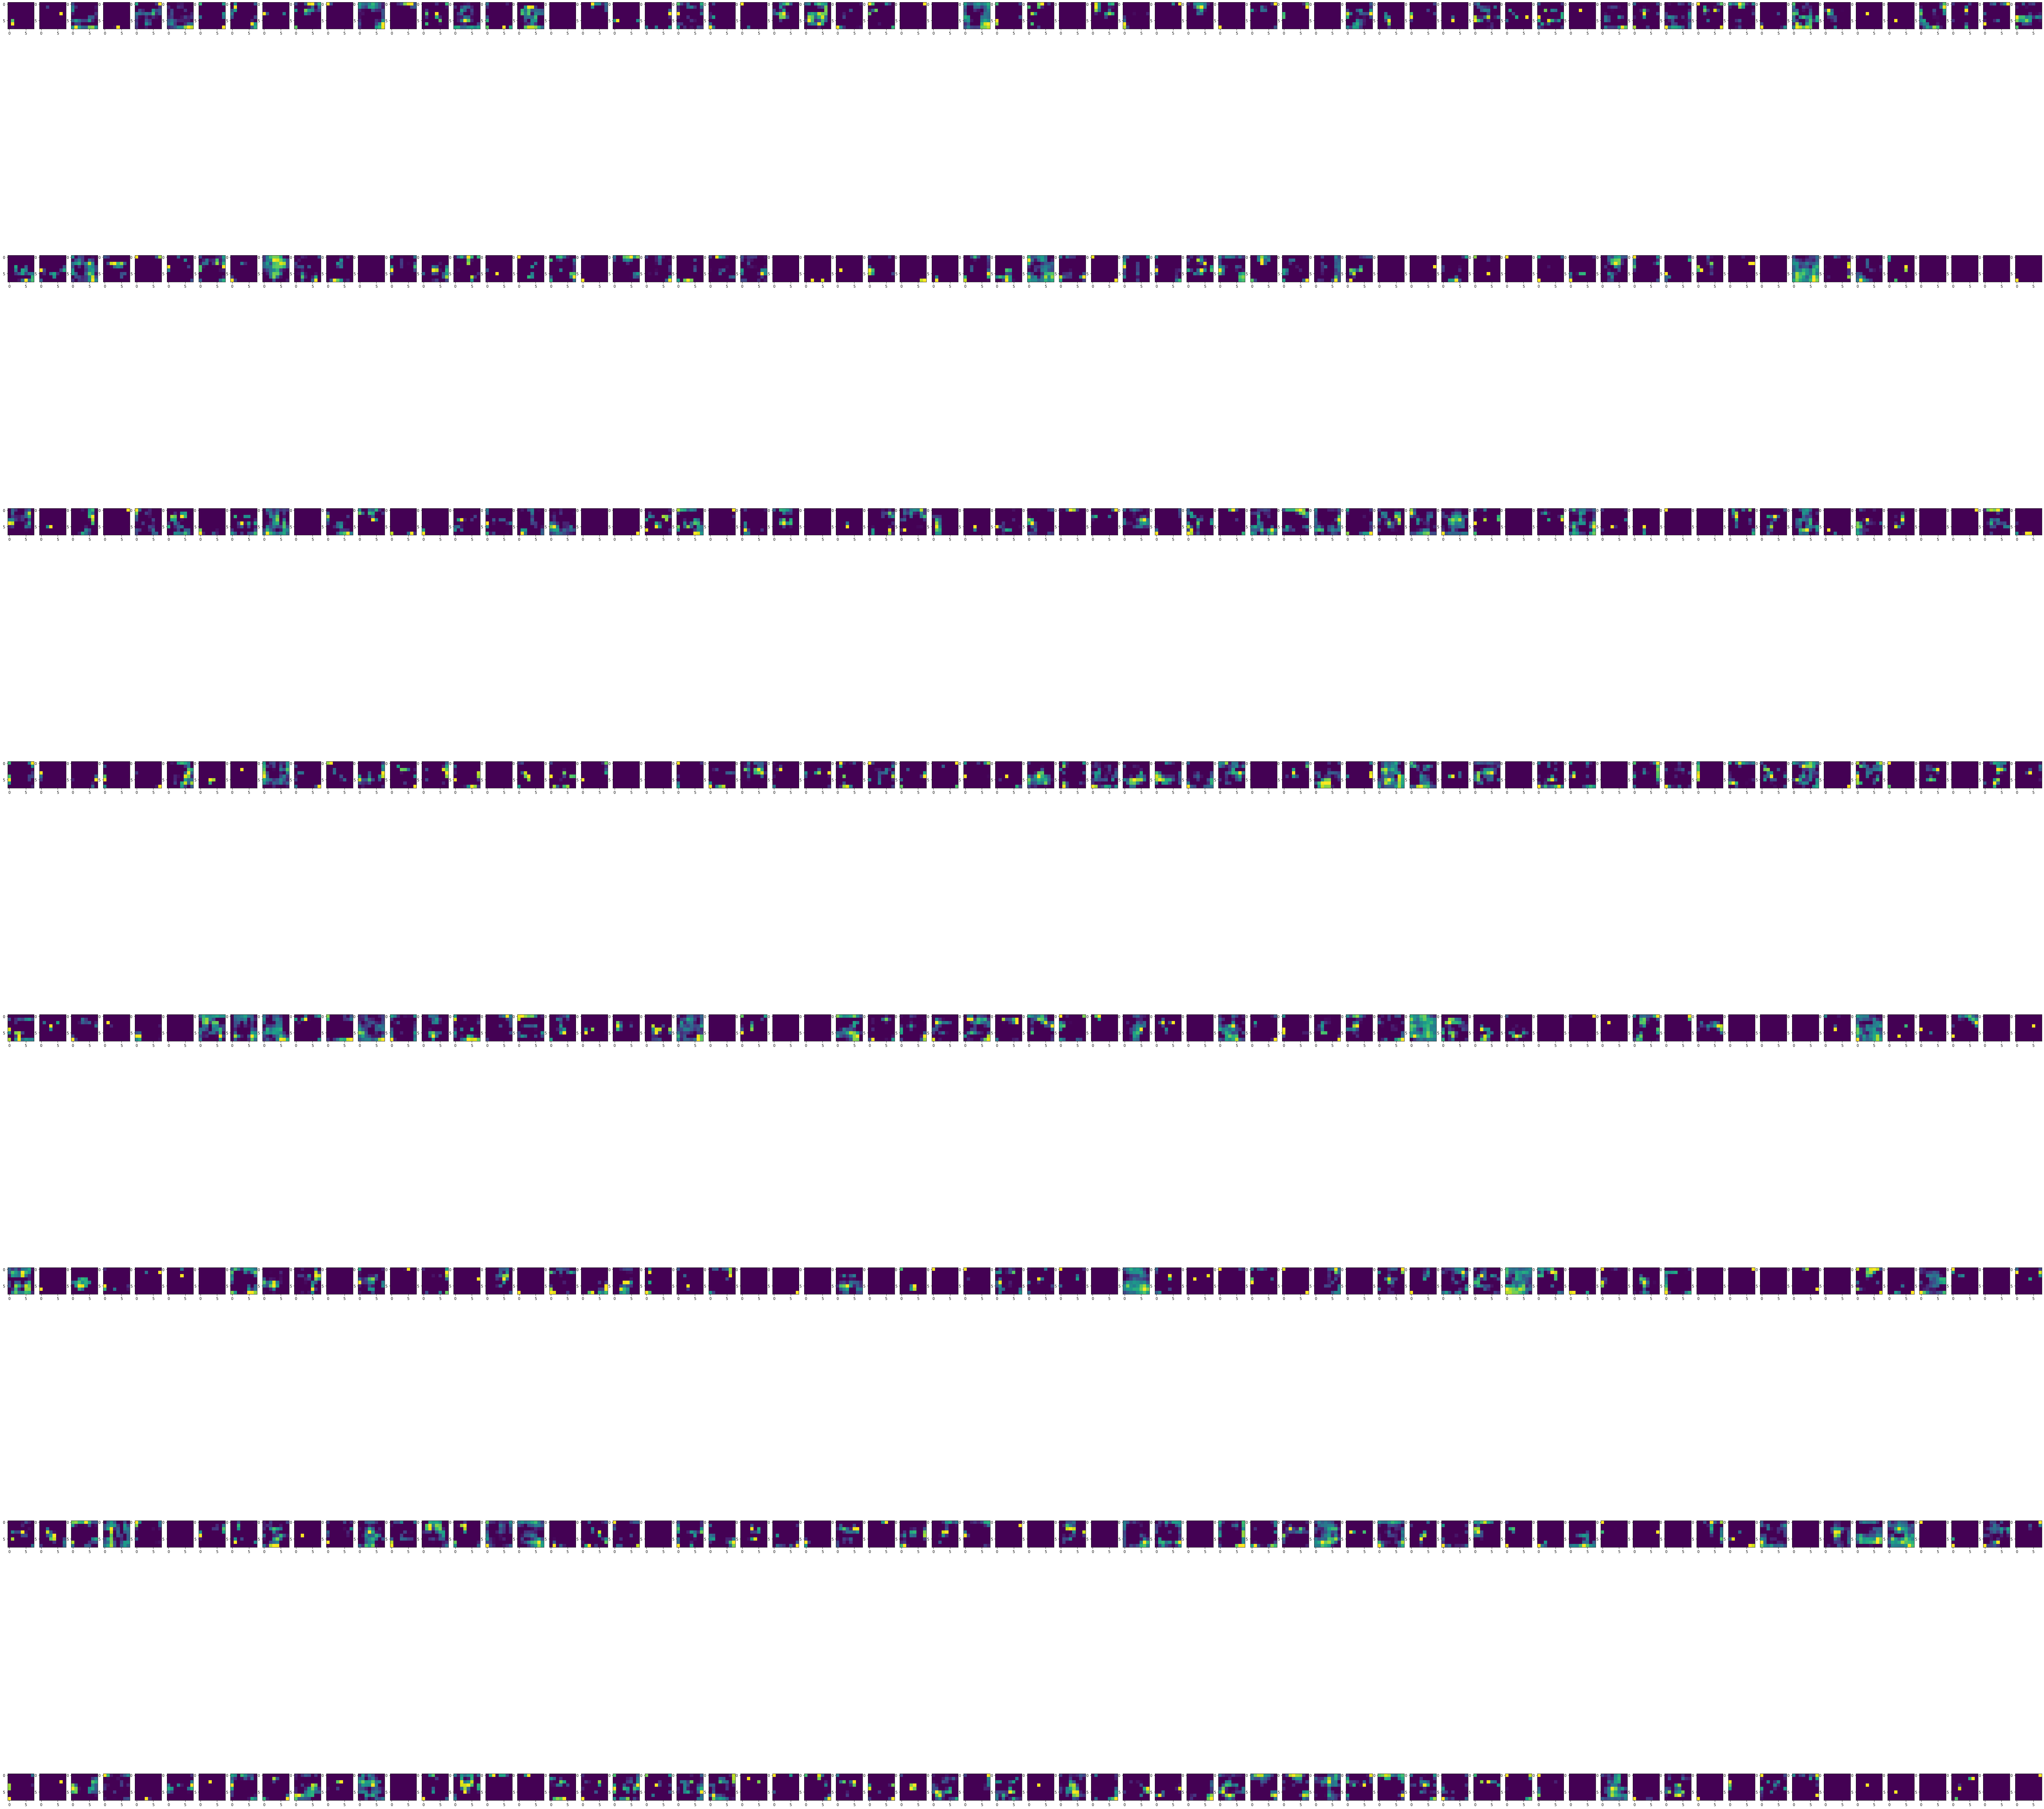

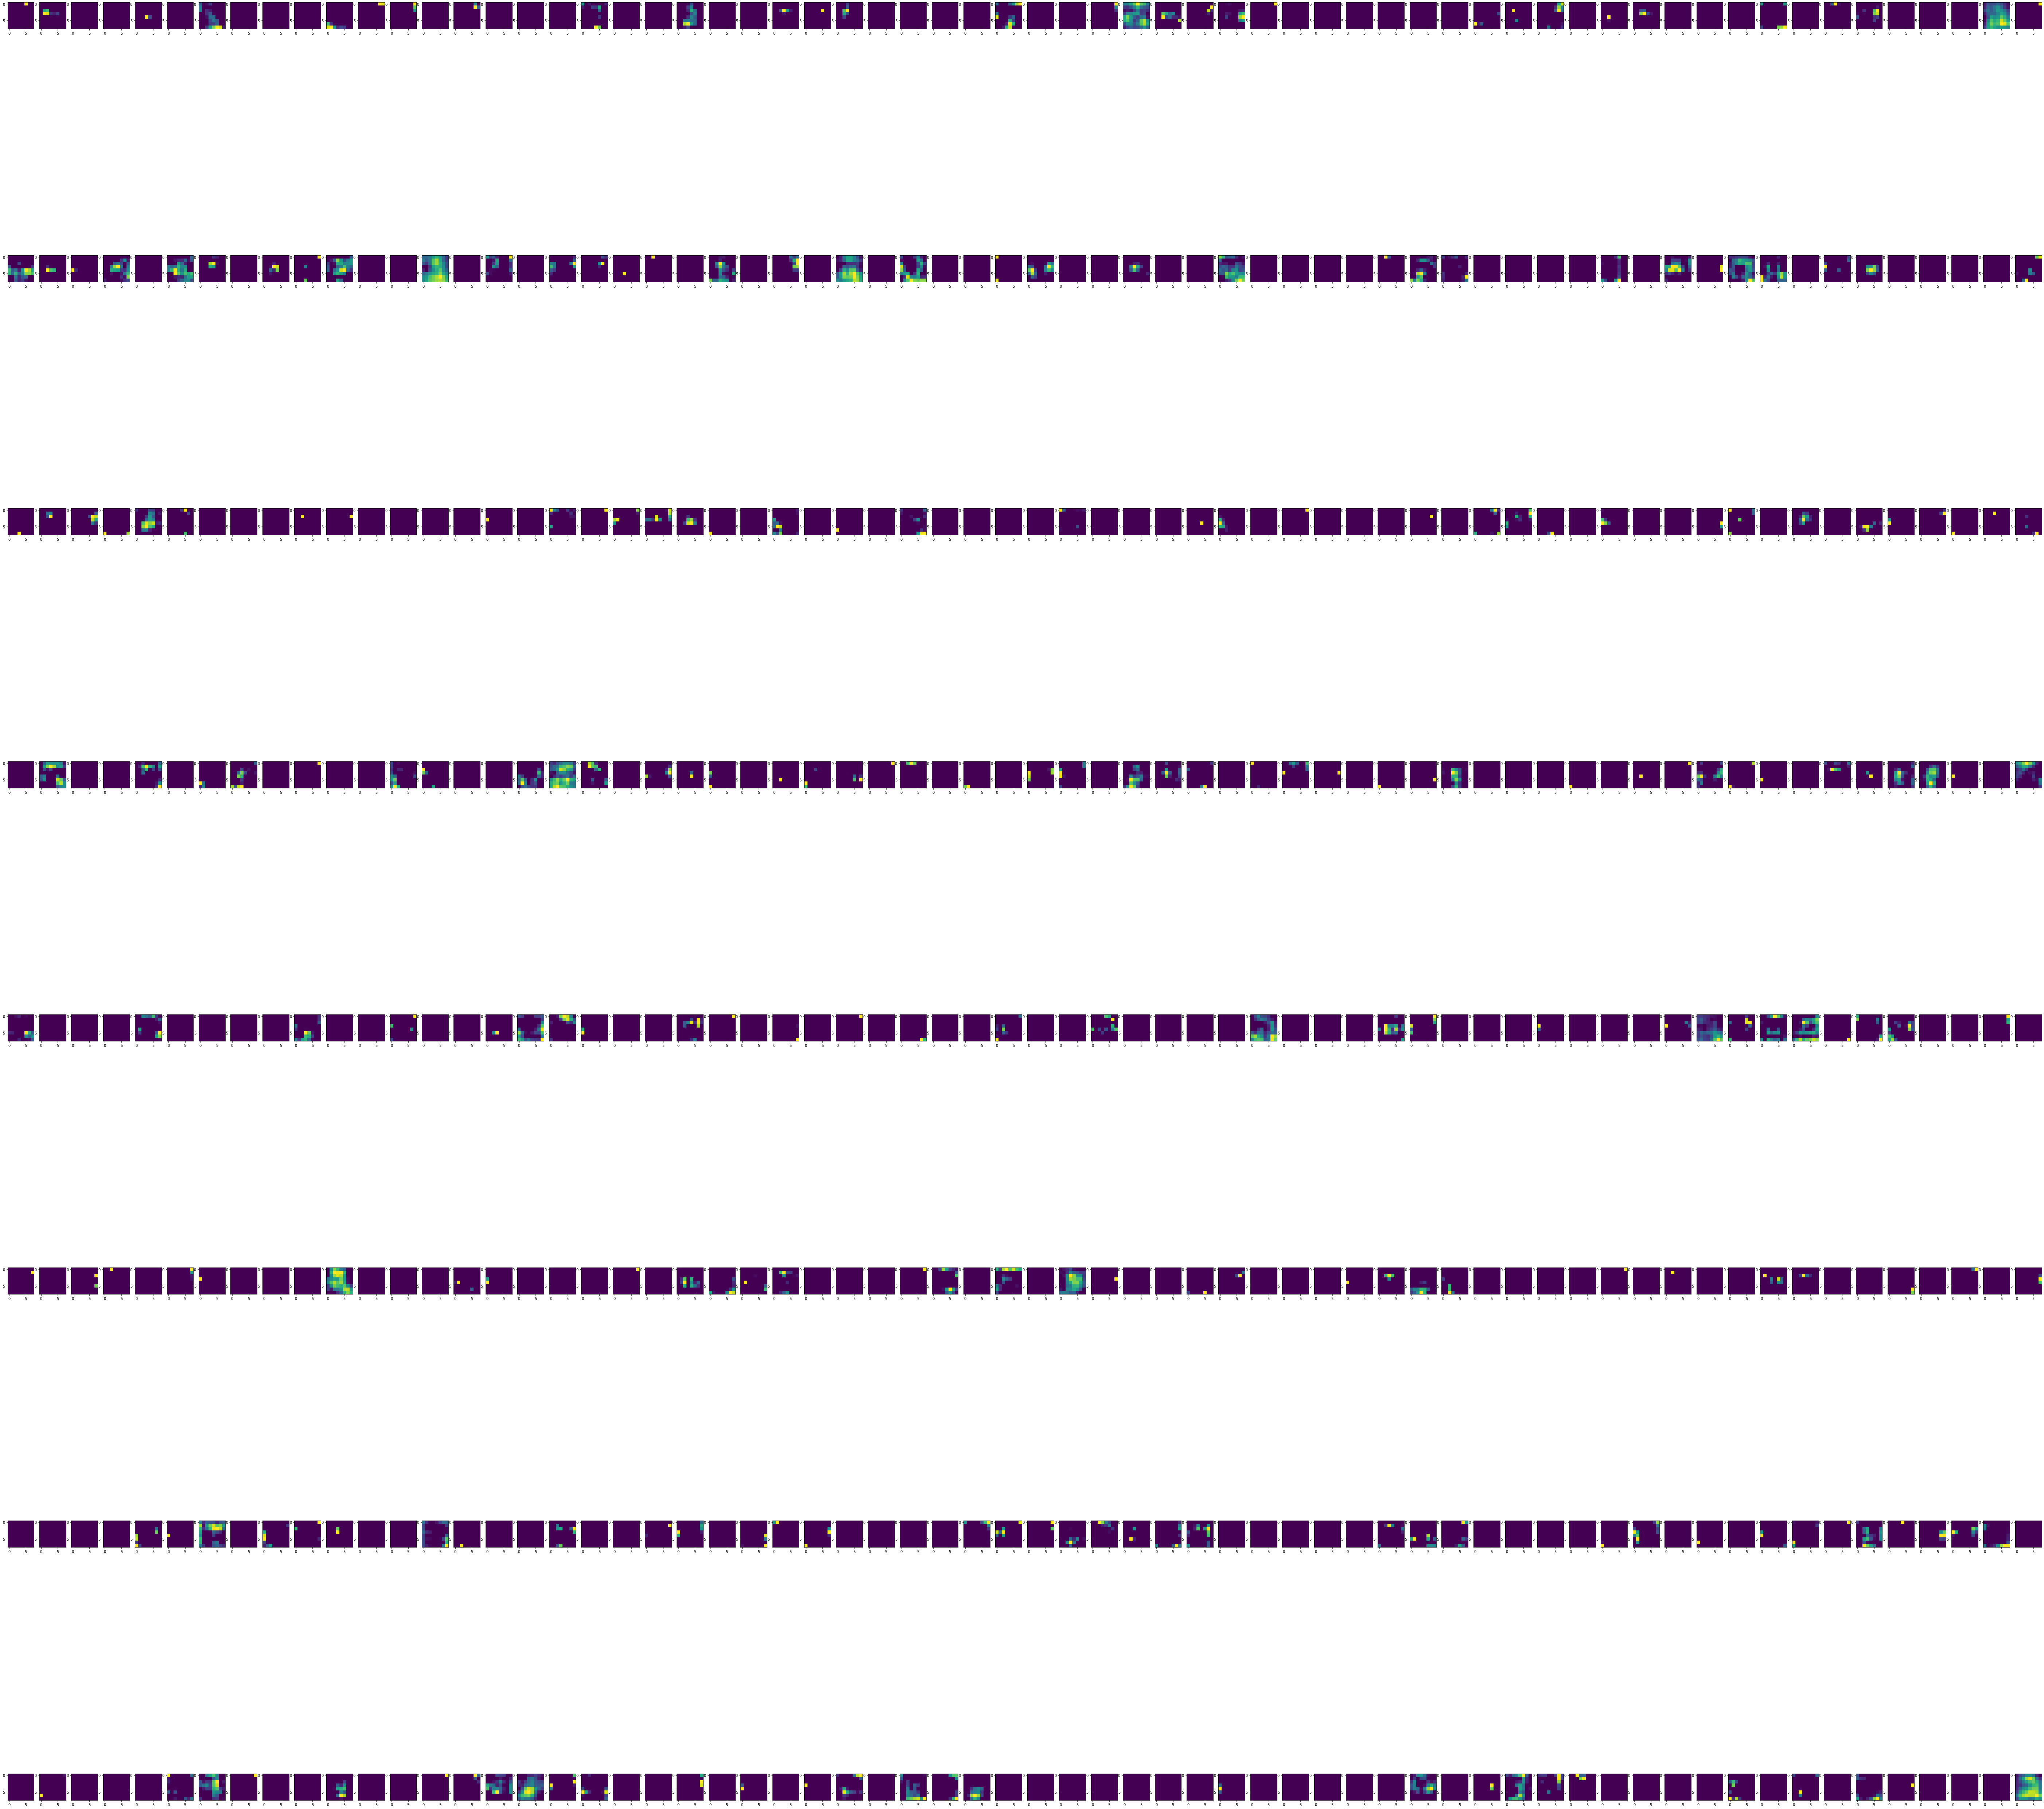

In [14]:
# plotting activations one layer at a time

for key in activation.keys():
    act = activation[key].squeeze()

    figure, axes = plt.subplots(8, int(act.size(0)/8), figsize = (100,100))

    print('Activations for layer:', key)
    for idx in range(int(act.size(0))):
        axes[idx%8][idx//8].imshow(act[idx].cpu())